# We know *where aircraft flew.*  What were their acoustic properties on the ground?

Current issues: https://github.com/dbetchkal/NMSIM-Python/issues

In [1]:
# this module contains a list of libraries, functions, and global constants used in this workbook
# import everything using wildcard (*)
from NMSIM_DENA_Flight_Tracks import *

#### <font color="gray">Reference *[Optional]:*</font> using `iyore` what sites were deployed concurrent to GPS data collection?
 <font color="gray">Use this cell if you need a refresher on the available sites.</font>

In [ ]:
# find Denali sites from 2019, 2020
np.unique([e.site for e in archive.dataDir(unit="DENA", year=["2019", "2020"])])

## Step 1: Select GPS points, convert to NMSIM trajectories *(.trj)*
**Also create an NMSIM *.sit* file!** <br><br>
Given
>NPS monitoring site <br>
>year <br>
>how far away are you interested in vehicle motion (kilometers) <br>

#### <font color=salmon size=4>You must edit lines 3 - 5.</font>

In [ ]:
help(query_tracks)

DENAK5Z52015: 599542, 7047550 - UTM zone 5
	microphone height 4.20 feet.

	Shapefile containing 25km radius buffer has been written!


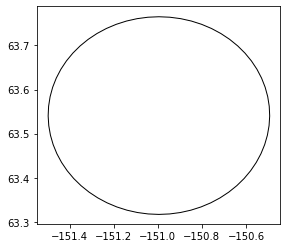


	Record begins 2015-06-04 and ends 2015-09-01 

		 Flight starting 2012-03-13 10:57:00 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201203131015 expected closest at 2012-03-13 14:26:00 0.0km

			 Flight is within search distance. Attempting to densify 14 points...
trying for 198 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 12276 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 13914 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 20

			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2012-05-17 11:46:00 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201205171145 expected closest at 2012-05-17 11:47:00 0.2km

			 Flight is within search distance. Attempting to densify 17 points...
trying for 66 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 3960 steps between points
trying for 198 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 5925 points!

			 Densification co

			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2012-10-10 14:21:00 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201210101415 expected closest at 2012-10-10 14:22:00 0.1km

			 Flight is within search distance. Attempting to densify 10 points...
trying for 66 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 1114 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2012-10-16 11:50:00 has no matching acoustic record. Proceeding by user overrid

			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-03-03 11:53:00 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201303031100 expected closest at 2013-03-03 14:53:00 0.3km

			 Flight is within search distance. Attempting to densify 14 points...
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 10362 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 66 steps between points
trying for 132 steps between points
			 ...trajectory now has 11868 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------

trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 526 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-05-22 14:06:00 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201305221400 expected closest at 2013-05-22 14:06:00 0.1km

			 Flight is within search distance. Attempting to densify 6 points...
trying for 0 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 526 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-08-07 10:49:00 has 

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

			 ...trajectory now has 1316 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2019-02-20 10:22:23 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201902200945 expected closest at 2019-02-20 10:29:11 12.8km

			 Flight is within search distance. Attempting to densify 887 points...
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between po

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
			 ...trajectory now has 887 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------


C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


		 Flight starting 2019-02-20 12:45:53 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201902201130 expected closest at 2019-02-20 14:35:42 0.0km

			 Flight is within search distance. Attempting to densify 6844 points...
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
			 ...trajectory now has 6844 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2019-02-20 15:07:15 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201902201500 expected closes

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 13 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 5 steps between points
trying for 2 steps between points
trying for 5 steps between points
trying for 4 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 1 

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 7 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 5 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 4 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 4 steps between points
trying for 4 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 3 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 8 steps between points
trying for 2 steps between points
trying for 5 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 4 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 3 steps between points
trying for 2 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 4 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 4 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 2 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 3 steps between points
trying for 5 steps between points
trying for 5 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
			 ...trajectory now has 19579 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2019-06-04 12:00:36 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201906041200 expected closest at 2019-06-04 12:03:28 0.0km

			 Flight is within search distance. Attempting to densify 734 points...
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between po

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 4 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


		 Flight starting 2019-08-26 11:24:16 has no matching acoustic record. Proceeding by user override.
		 #N21HY_201908261045 expected closest at 2019-08-26 11:37:19 0.0km

			 Flight is within search distance. Attempting to densify 1415 points...
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 4 steps between points
trying for 3 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 5 steps between points
trying for 2 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 3 steps between points
trying for 2 steps betwe

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 steps between points
trying for 1 s

			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-03-02 14:01:00 has no matching acoustic record. Proceeding by user override.
		 #N3967Z_201303020845 expected closest at 2013-03-02 14:11:00 0.7km

			 Flight is within search distance. Attempting to densify 7 points...
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 0 steps between points
			 ...trajectory now has 657 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-03-03 10:51:00 has no matching acoustic record. Proceeding by user override.
		 #N3967Z_201303031015 expected closest at 2013-03-03 14:29:00 0.3km

			 Flight is within search distance

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))
C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 6996 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 264 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 0 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 264 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 792 steps between points
trying for 132 steps between 

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-03-04 13:09:00 has no matching acoustic record. Proceeding by user override.
		 #N3967Z_201303041300 expected closest at 2013-03-04 13:11:00 7.7km

			 Flight is within search distance. Attempting to densify 8 points...
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 0 steps between points
trying for 132 steps between points
			 ...trajectory now has 788 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-07-24 17:22:00 has no matching acoustic record. Proceeding by user override.


C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


		 #N3967Z_201307241530 expected closest at 2013-07-24 17:46:00 3.7km

			 Flight is within search distance. Attempting to densify 20 points...
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 2490 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


		 Flight starting 2012-08-04 11:46:14 has no matching acoustic record. Proceeding by user override.
		 #N403AE_201208041100 expected closest at 2012-08-04 11:56:16 11.6km

			 Flight is within search distance. Attempting to densify 6 points...
trying for 130 steps between points
trying for 132 steps between points
trying for 135 steps between points
trying for 127 steps between points
trying for 136 steps between points
			 ...trajectory now has 656 points!

			 Densification complete, writing trajectory file...
			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2012-08-04 14:24:04 has no matching acoustic record. Proceeding by user override.
		 #N403AE_201208041415 expected closest at 2012-08-04 14:28:19 9.1km

			 Flight is within search distance. Attempting to densify 5 points...
trying for 136 steps between points
trying for 144 steps between points
trying for 157 steps between points
trying fo

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 132 steps between points
trying for 119 steps between points
trying for 132 steps between points
trying for 141 steps between points
trying for 133 steps between points
trying for 41 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 130 steps between points
trying for 71 steps between points
trying for 130 steps between points
trying for 133 steps between points
trying for 132 steps between points
trying for 79 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 140 steps between points
trying for 133 steps between points
trying for 3415 steps between points
trying for 132 steps between points
trying for 133 steps between points
trying for 135 steps between points
trying for 40 steps between points
trying for 135 steps between points
trying for 129 steps between points
			 ...trajectory now has 7179 points!

			 Densification complete, writing trajectory file...
			...fi

			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-07-14 12:15:40 has no matching acoustic record. Proceeding by user override.
		 #N403AE_201307141045 expected closest at 2013-07-14 12:23:40 0.0km

			 Flight is within search distance. Attempting to densify 8 points...
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 815 steps between points
trying for 132 steps between points
trying for 132 steps between points
			 ...trajectory now has 1601 points!

			 Densification complete, writing trajectory file...


C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


			...finished writing .trj 

-----------------------------------------------------------------------------------------
		 Flight starting 2013-07-14 13:30:50 has no matching acoustic record. Proceeding by user override.
		 #N403AE_201307141330 expected closest at 2013-07-14 13:33:29 0.0km

			 Flight is within search distance. Attempting to densify 43 points...
trying for 132 steps between points
trying for 42 steps between points
trying for 132 steps between points
trying for 129 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 1316 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 66 steps between points
trying for 95 steps between points
trying for 132 steps between points
trying for 134 steps between points
trying for 132 steps betw

C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:116: RuntimeWarning: invalid value encountered in double_scalars
  degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))


trying for 132 steps between points
trying for 71 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 135 steps between points
trying for 128 steps between points
trying for 133 steps between points
trying for 44 steps between points
trying for 128 steps between points
trying for 135 steps between points
trying for 129 steps between points
trying for 48 steps between points
trying for 139 steps between points
trying for 137 steps between points
trying for 135 steps between points
trying for 110 steps between points
trying for 132 steps between points
trying for 114 steps between points
trying for 132 steps between points
trying for 74 steps between points
trying for 77 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 635 steps between points
trying for 132 steps between points
trying for 132 steps between points
trying for 132 steps between poin

ValueError: NaTType does not support timetuple

In [2]:
# =============  EDIT  =====================================================
#   DEFINE THE PROJECT DIRECTORY and YEAR
project_dir = r"D:\Sound\NMSIm_Projects\DENAK5Z5"
year = 2015
how_far_away = 25 # km
# ==========================================================================

# extract the site name from the project directory path
site = project_dir[-4:]

# create a table of all the flights
tracks = tracks_within(archive, site, year, 
                       search_within_km = how_far_away, 
                       aircraft_specs=False,
                       NMSIM_proj_dir = project_dir,
                       decouple=True)

# which N-Numbers were observed on this record?
tracks.registration.unique()

## Step 2: Run the models in NMSIM
#### <font color=salmon>Repeat for each N-Number of interest, *then* proceed to the next cell.</font>

In [ ]:
# ============= EDIT ===================================================

# FAA registry for aircraft of interest
Focal_NNumber = "N74PS"

# ======================================================================

# NMSIM program directiory
NMSIMpath = os.path.dirname(os.path.dirname(project_dir))

# lookup for appropriate NMSIM source file
source_map = {"N8888": NMSIMpath + os.sep + "Sources\MiscellaneousSources\omni.src",
              "N709M": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src",
             "N570AE": NMSIMpath + os.sep + "Sources\AirTourHelicopterSources\AS350.src",
              "N74PS": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N619CH": NMSIMpath + os.sep +  "Sources\AirTourFixedWingSources\C207.src",
             "N72309": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N72395": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N473YC": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N21HY":  NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src"}


# run the NMSIM model
NMSIM_create_tis(project_dir, source_map[Focal_NNumber], Nnumber=Focal_NNumber)

## Step 3: Pair NMSIM results to NPS acoustic measurements

In [ ]:
# NMSIM isn't always successful - we want to iterate only through files that WERE created
trj_and_tis = pair_trj_to_tis_results(project_dir)

# (whether or not to show diagnostic plots; default: False)
diagnostic = False

for trj, tis in trj_and_tis:
    
    print(trj, "\n", tis)
    
    runName = os.path.basename(trj)[:-4]
    
    # read just the header of the trajectory
    with open(trj) as lines:
        head = [next(lines) for x in range(12)]

    # here's the string containing the starting time (to the second!)
    dateString = head[-1][-24:-5]

    # convert to a datetime object
    startdate = dt.datetime.strptime(dateString, "%Y-%m-%d %H:%M:%S")

    print("now working on run:", runName)
    
    try:
        # this is the theoretical 1/3rd octave band trace
        theory = tis_resampler(tis, startdate)
        
    except:
        print("tis", tis)
        print("produced a ValueError related to nan values in the .tis file")
    
    
    # compare and save results
    event_SPL = NVSPL_to_match_tis(archive, project_dir, 
                                   startdate, theory, trj, 
                                   unit="DENA", site=site, year=int(startdate.year),
                                   utc_offset=-8, pad_length=5)
    
    # show diagnostic plots
    if(diagnostic == True):
        
        plt.figure(figsize=(14, 3))
        plt.plot(theory.index, theory["A"], zorder=5, ls="", marker="o", ms=2)
        plt.legend(loc="best")
        plt.show()